In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import os

import utils.datasets as datasets
import utils.sde_lib as sdes
from utils.models import MLP
from utils.misc import dotdict, batch_matrix_product

torch.set_printoptions(precision=3,sci_mode=False)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n = 1000
# covs = torch.tensor([[[3., -1.],[-1., 2.]], [[3., 1.8],[1.8, 2.]], [[3., -1.],[-1., 2.]]], device=device)
# means = torch.tensor([[0,3.], [10,5.], [-6.,0]],device=device)
# weights = torch.ones(means.shape[0],device=device)/means.shape[0]
# gmm = GMM(weights,means,covs)
dataset = datasets.get_dataset(dotdict({'dataset' : 'spiral'}))
data = dataset.sample(5).to(device=device)

sde = sdes.LinearSchrodingerBridge(2,device)
model = MLP(2,False).to(device=device)

eps = sde.delta
times = (torch.rand((data.shape[0]),device=data.device) * (1-eps) + eps) * sde.T()
shaped_t = times.reshape(-1,1,1,1) if len(data.shape) > 2 else times.reshape(-1,1)
# mean, L, invL, _ = sde.marginal_prob(data,shaped_t)
# noise = torch.randn_like(mean,device=data.device)
# perturbed_data = mean + torch.bmm(L, noise.unsqueeze(-1)).squeeze(-1)
# flatten_error = ((torch.bmm(invL.mT, noise.unsqueeze(-1)).squeeze(-1) + model(perturbed_data,times))**2).view(data.shape[0],-1)


# std = (1-torch.exp(-sde.beta_int(shaped_t)))**.5

# print(times)
# print((std).cpu().numpy())
# print(L[:,0,0].cpu().numpy())

# print(L)
# print(invL.mT)

# print(perturbed_data)
# print(torch.exp(-sde.beta_int(shaped_t)/2) * data + noise * std)

# print(torch.bmm(invL.mT, noise.unsqueeze(-1)).squeeze(-1))
# print(noise / std)

# plt.scatter(data[:,0], data[:,1])
# plt.show()


# print(-.5 * sde.beta(shaped_t) * perturbed_data)
# print(-.5 * sde.beta(shaped_t) * batch_matrix_product(sde.A(shaped_t),perturbed_data))
# print(sde.drift(perturbed_data,shaped_t))


tensor([[ 0.696,  0.313],
        [-0.554, -0.319]], grad_fn=<ViewBackward0>)


In [3]:
t = shaped_t
int_mat = sde.int_beta_ds(t)
print(int_mat)
dim = int_mat.shape[-1]
C_H_power = torch.zeros((t.shape[0], 2 * dim, 2 * dim),device=int_mat.device)
C_H_pair = torch.zeros_like(C_H_power)
C_H_power[:,:dim, :dim] = -.5 * int_mat
C_H_power[:,-dim:, -dim:] = .5 * int_mat
C_H_power[:, :dim, dim:] = sde.beta_int(t).view(-1,1,1) * torch.eye(dim,device=int_mat.device).unsqueeze(0).expand(t.shape[0],-1,-1)


print(C_H_power)
C_H_pair = torch.linalg.matrix_exp(C_H_power)
initial_cond = torch.cat((torch.zeros((dim,dim), device=int_mat.device), torch.eye(dim,device=int_mat.device)), dim=0)
C_H = torch.einsum('tij,jk->tik', C_H_pair, initial_cond)
C = C_H[:, : dim, :]
H = C_H[:, dim: , :]
cov = torch.einsum('tij,tjk->tik', C, torch.linalg.inv(H))
L = torch.linalg.cholesky(cov)
invL = torch.linalg.inv(L.mH)
print(C_H_pair)

tensor([[[-4.680,  0.540],
         [ 0.540,  5.828]],

        [[-2.977,  0.408],
         [ 0.408,  3.720]],

        [[-1.120,  0.199],
         [ 0.199,  1.409]],

        [[-0.450,  0.093],
         [ 0.093,  0.569]],

        [[-7.844,  0.694],
         [ 0.694,  9.727]]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[[ 2.340, -0.270,  1.930,  0.000],
         [-0.270, -2.914,  0.000,  1.930],
         [ 0.000,  0.000, -2.340,  0.270],
         [ 0.000,  0.000,  0.270,  2.914]],

        [[ 1.489, -0.204,  1.290,  0.000],
         [-0.204, -1.860,  0.000,  1.290],
         [ 0.000,  0.000, -1.489,  0.204],
         [ 0.000,  0.000,  0.204,  1.860]],

        [[ 0.560, -0.099,  0.529,  0.000],
         [-0.099, -0.704,  0.000,  0.529],
         [ 0.000,  0.000, -0.560,  0.099],
         [ 0.000,  0.000,  0.099,  0.704]],

        [[ 0.225, -0.046,  0.225,  0.000],
         [-0.046, -0.284,  0.000,  0.225],
         [ 0.000,  0.000, -0.225,  0.046],
         [ 0.000,  0.000,  0

In [4]:
ts = torch.linspace(.1,sde.T(), 6,device=device).unsqueeze(-1)
cov, L, invL, _ = sde.compute_variance(ts)
print(L)
print(invL)

tensor([[[     0.229,     -0.001],
         [    -0.001,      0.217]],

        [[     0.778,     -0.024],
         [    -0.024,      0.496]],

        [[     2.104,     -0.099],
         [    -0.099,      0.584]],

        [[     7.861,     -0.363],
         [    -0.363,      0.590]],

        [[    51.954,     -1.877],
         [    -1.877,      0.622]],

        [[   690.472,    -17.226],
         [   -17.226,      0.966]]], device='cuda:0',
       grad_fn=<UnsafeViewBackward0>)
tensor([[[    4.367,     0.025],
         [    0.025,     4.606]],

        [[    1.287,     0.061],
         [    0.061,     2.018]],

        [[    0.479,     0.081],
         [    0.081,     1.725]],

        [[    0.131,     0.081],
         [    0.081,     1.746]],

        [[    0.022,     0.065],
         [    0.065,     1.805]],

        [[    0.003,     0.047],
         [    0.047,     1.865]]], device='cuda:0',
       grad_fn=<UnsafeViewBackward0>)


In [5]:
A = torch.tensor([[ 0.9150,  0.8235],[-0.9749,  0.3197]],device=device)
D = torch.eye(2,device=device) - 2  * (A + A.T)

print(D)
print(torch.linalg.eigh(D))
# print(sde.compute_variance(torch.tensor([[sde.T()]],device=device)))

tensor([[-2.660,  0.303],
        [ 0.303, -0.279]], device='cuda:0')
torch.return_types.linalg_eigh(
eigenvalues=tensor([-2.698, -0.241], device='cuda:0'),
eigenvectors=tensor([[ 0.992,  0.124],
        [-0.124,  0.992]], device='cuda:0'))


In [6]:
model_path = './checkpoints/spiral_sb_linear/itr_2000'
forward_score = torch.load(os.path.join(model_path,'forward_ema_2000.pt'))
backward_score = torch.load(os.path.join(model_path,'backward_ema_2000.pt'))

sde = sdes.SchrodingerBridge(forward_score,backward_score)

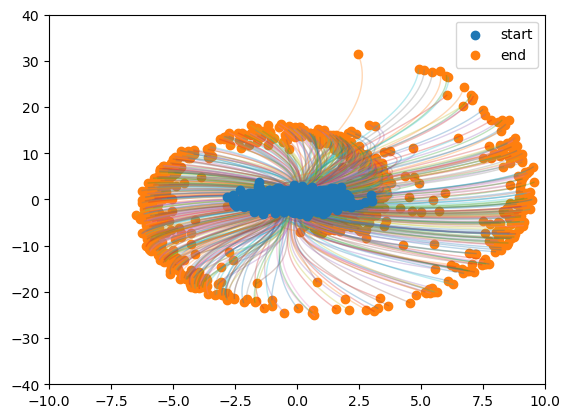

In [8]:
dataset = datasets.Spiral(y_scalar=3.2)
n_samples = 1000
in_cond = dataset.sample(n_samples).to(device=device)
xt, traj = sde.sample((n_samples,2), device, backward=True, in_cond=in_cond)
xt, traj = sde.probability_flow((n_samples,2), device, backward=True, in_cond=in_cond)

# for i in range(traj.shape[1]):
#     xi = traj[:,i]
    
#     plt.xlim([-16,16])
#     plt.ylim([-16,16])
#     plt.scatter(xi[:,0].cpu(), xi[:,1].cpu())
#     plt.savefig(f'./trajectory/{i}.png')
#     plt.clf()



for i in range(traj.shape[0]):
    xi = traj[i]
    plt.plot(xi[:,0].cpu(), xi[:,1].cpu(), linewidth=1, alpha=.3)

plt.xlim(-10,10)
plt.ylim(-40,40)
plt.scatter(traj[:,0,0].cpu(), traj[:,0,1].cpu(),label='start',zorder=1010)
plt.scatter(traj[:,-1:,0].cpu(), traj[:,-1,1].cpu(),label='end')
plt.legend()
plt.show()